## 1. Постановка задачи

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени. <center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. 

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.

## 2. Знакомство с данными. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.

In [2]:
# Подгружаем датасет
data = pd.read_csv(
    "data/customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)

# Выводим размерность
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


In [17]:
# Посмотрим на типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [3]:
# Посмотрим в каких признаках есть пропуски данных
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Посмотрим за какой временной период содержатся данные в датасете.

In [6]:
# Приводим признак 'InvoiceDate' к типу данных datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']) 
# Начальная дата
print(f' Начальная дата: {data["InvoiceDate"].sort_values().dt.date[0]}')
# Конечная дата
print(f' Конечная дата: {data["InvoiceDate"].sort_values().dt.date.tolist()[-1]}')

 Начальная дата: 2010-12-01
 Конечная дата: 2011-12-09


Данные представлены за годовой период

Посмотрим на описательные статистики

In [7]:
data.describe().astype('int')

,Quantity,UnitPrice
count,541909,541909
mean,9,4
std,218,96
min,-80995,-11062
25%,1,1
50%,3,2
75%,10,4
max,80995,38970


+ **Quantity**: В большинстве случаев покупатели приобретают товары в количестве от 1 до 10. Медианное количество - 3. Минимальная и максимальная границы с одинаковыми аномальными значениями. Поэтому среднее значение на уровне 9 и большое стандартное отклонение.
+ **UnitPrice**: Цена товара имеет похожие характеристики. Чаще всего покупатели приобретают товары стоимостью от 1 дл 4 фунтов. Максимальное и минимальное значения также имеют большой разброс. 

In [8]:
# Минимальная цена товара, если рассматривать только положительные значения
min_price = min(list(filter(lambda x: x >= 0, data['UnitPrice'])))
min_price

0.0

In [9]:
data.describe(include='object')

,InvoiceNo,StockCode,Description,CustomerID,Country
count,541909,541909,540455,406829,541909
unique,25900,4070,4223,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17841,United Kingdom
freq,1114,2313,2369,7983,495478


Чаще всего клиенты приобретают белый подвесной подсвечник в виде сердца. Товар встречается 2369 раз из 4223 наименований.

Большая часть товаров приобретается клиентами из Великобритании - 495478 из 541909. В датасете представлены 38 стран.

## 3. Предобработка и очистка данных

### 3.1
Начнем с пропусков. 

In [10]:
# Общее количество пропущенных значений
data.isnull().sum().sum()

136534

In [11]:
# Доля пропущенных значений в признаках
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
print(cols_with_null)

CustomerID     24.926694
Description     0.268311
dtype: float64


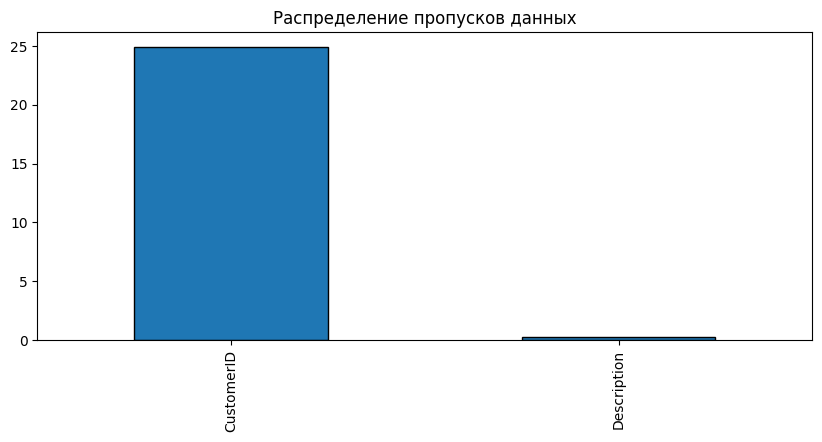

In [12]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков данных'
);

Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалим все записи, где есть пропущенные значения.

In [13]:
data = data.dropna(axis=0)
data.shape

(406829, 8)

In [14]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### 3.2
Следом за пропусками проверим наличие дубликатов.

In [15]:
dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
data_dupl = data[mask]
print(f'Количество строк, которые полностью дублирут друг друга: {data_dupl.shape[0]}')

Количество строк, которые полностью дублирут друг друга: 5225


In [16]:
# Удаляем дубликаты
data = data.drop_duplicates(subset=dupl_columns)
# Выводим оставшееся количество записей
data.shape[0]

401604

Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [19]:
negative_quantity = data[(data['Quantity']<0)]
print(f'Количество записей с отрицательными значениями: {negative_quantity.shape[0]}')
negative_quantity.head()

Количество записей с отрицательными значениями: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Таких записей почти девять тысяч. Не похоже на какую-то ошибку или выбросы, случаев слишком много.

При просмотре таблицы можно заметить следующее:

+ Номер заказа (InvoiceNo) и код товара (StockCode) могут содержать не только числа, но и символы.
+ Как было сказано в описании датасета, символ "C" перед номером заказа указывает на возврат. То есть, по идее, в таблице должна также находиться запись с точно такими же идентификаторами клиента и товара, но c номером заказа без символа "C" и c положительным количеством товара.
+ Код товара может содержать различные специальные символы: например, символ "D", судя по описанию товара (столбец Description), означает наличие скидки.
+ Как на каждый уникальный товар, так и на его возврат заводится отдельная транзакция (запись в таблице).

### 3.3
Проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

Посчитаем количество транзакций из таблицы negative_quantity, которые не содержат в номере заказа признак возврата.

In [21]:
count = 0
for i in negative_quantity['InvoiceNo']:
    if "C" not in i:
        count += 1
        
print(f'Количество транзакций из таблицы negative_quantity, \nкоторые не содержат в номере заказа признак возврата {count}')

Количество транзакций из таблицы negative_quantity, 
которые не содержат в номере заказа признак возврата 0


Подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:

In [22]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Добавим во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Посчитаем процент заказов в таблице, которые являются возвратами. 

In [25]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if "C" in x else 0)
print(f' Возвратных заказов: {int((nb_products_per_basket["order_canceled"].sum() / nb_products_per_basket["order_canceled"].count()) * 100)} %')

 Возвратных заказов: 16 %


Взглянем на отмененные заказы:


In [26]:
nb_products_per_basket[nb_products_per_basket['order_canceled'] == 1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [27]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена». Сравним столбцы StockCode, UnitPrice, CustomerID и Quantity. Они имеют одинаковые значения.

**Выдвигаем гипотезу:** для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

Проитериуемся по признаку CustomerID в таблице с отрицательным количеством товаров. Если индетификатор клиента отсутствует в таблице с данными, то будем считать их количество.

In [82]:
count = 0
for i in negative_quantity['CustomerID']:
    if i not in data['CustomerID']:
        count += 1
print(count)       
    

8872


Гипотеза не подтвердилась: не все заказы с отрицательным количеством товара имеют в таблице свои аналоги. Нужно дальше разбираться, почему так происходит.

Приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [28]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


В первой строке, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров нет. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

**Выдвигаем новую гипотезу:** для каждой отменённой транзакции в базе данных  существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Таким же образом посчитаем количество совпадающих инентификаторов.

In [29]:
not_discount = negative_quantity[negative_quantity['StockCode'] != 'D']
count = 0
for i in not_discount['CustomerID']:
    if i not in data['CustomerID']:
        count += 1
        
print(count)

8795


Эта гипотеза тоже не подтвердилась. Даже исключив товары со скидками, мы не можем найти аналогов для некоторых отменённых заказов.

Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [30]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
  
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). 

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:

1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).

Функция get_quantity_canceled принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.

In [31]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
quantity_canceled

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
541904    0.0
541905    0.0
541906    0.0
541907    0.0
541908    0.0
Length: 401604, dtype: float64

Подсчитайте суммарное количество отмененных товаров в столбце QuantityCanceled. 

In [32]:
data['quantity_canceled'] = quantity_canceled
data['quantity_canceled'].sum()

245266.0

Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара.  
Сколько записей осталось?

In [33]:
data = data.drop(index=negative_quantity.index.tolist())
print(f'Осталось {data.shape[0]} записей')

Осталось 392732 записей


Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Проверим, бывают ли другие специальные коды.

С помощью регулярных выражений найдём такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

In [34]:
literal_stock_code = data[data['StockCode'].str.contains(r'^[a-zA-Z]+', regex=True)]
literal_stock_code['StockCode'].unique()

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

In [35]:
# Удалим эти записи
data = data.drop(index=literal_stock_code.index)
print(f'Осталось {data.shape[0]} записей')

Осталось 391183 записей


Действительно, есть шесть специальных видов транзакций. Чтобы понять, что означают эти коды, можно заглянуть в столбец с описанием (Descriprion): POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.

Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 

Посчитаем количество таких транзакций

In [38]:
zero_price = data[data['UnitPrice'] == 0]
zero_price.shape[0]

33

Таких транзакций оказалось менее 1 %, поэтому их можно удалить.

In [39]:
data = data.drop(index=zero_price.index)
print(f'Осталось {data.shape[0]} записей')

Осталось 391150 записей


Сохраним очищенный датасет.

In [40]:
data.to_csv('data/cleaned.csv')

## 4. Разведывательный анализ данных

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


In [41]:
# Загружаем очищенный датасет
df = pd.read_csv('data/cleaned.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,quantity_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


### 4.1
Для начала выясним, в каких странах живут клиенты.

Построим график, отражающий количество уникальных клиентов в каждой из стран. 

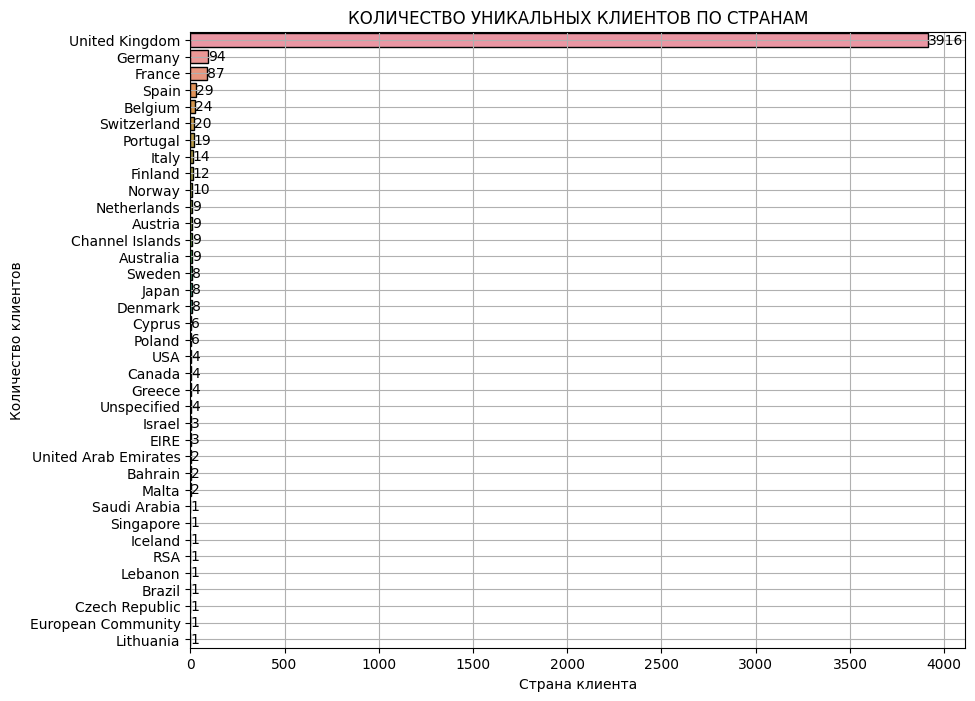

In [42]:
# Сгруппируем идентификаторы клиентов по странам
customers = df.groupby(by='CustomerID',
                       as_index=False)['Country'].value_counts()
customers = customers.drop_duplicates(subset='CustomerID')
 
fig = plt.figure(figsize=(10, 8))
bar = sns.barplot(customers,
                  y=customers['Country'].value_counts().index,
                  x=customers['Country'].value_counts().values,
                  errorbar=None
                )
bar.set_title('Количество уникальных клиентов по странам'.upper())
bar.set_ylabel('Количество клиентов')
bar.set_xlabel('Страна клиента')
bar.bar_label(bar.containers[0])
bar.grid();

Наибольшее количество клиентов проживает в Великобритании.

### 4.2

Выделим топ-3 страны по количеству поступающих заказов.

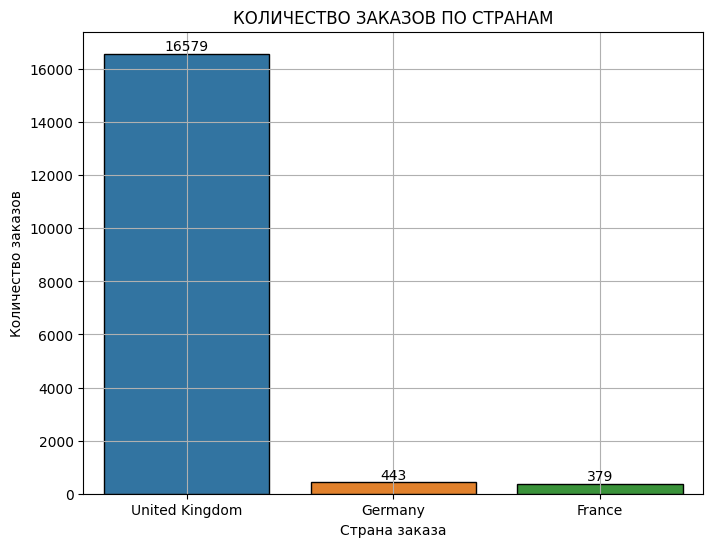

In [43]:
# Группируем номера заказов по странам
orders = df.groupby(by='InvoiceNo', as_index=False)['Country'].value_counts()

fig = plt.figure(figsize=(8, 6))
bar = sns.barplot(orders,
                  x=orders['Country'].value_counts().index[:3],
                  y=orders['Country'].value_counts().values[:3],
                  errorbar=None
                )
bar.set_title('Количество заказов по странам'.upper())
bar.set_ylabel('Количество заказов')
bar.set_xlabel('Страна заказа')
bar.bar_label(bar.containers[0])
bar.grid();

Большая часть заказов опять же из Великобритании. 

Таким образом, значительная часть клиентов находится в той же стране, чти и интернет-магазин.

### 4.3
Добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

In [44]:
df['TotalPrice'] = df['UnitPrice'] * (df['Quantity'] - df['quantity_canceled'])
print(f"Средняя общая стоимость заказа: {round(df['TotalPrice'].mean())} £")

Средняя общая стоимость заказа: 21 £


### 4.4

Выделим топ-3 страны, клиенты из которых приносят компании больше всего выручки:

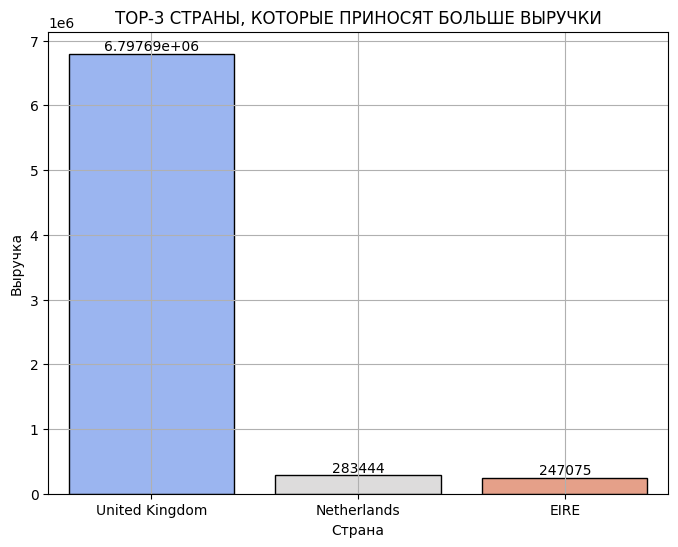

In [45]:
# Сгруппируем страны по общей цене
revenue = df.groupby(by='Country',
                     as_index=False)['TotalPrice'].sum().sort_values(by='TotalPrice',
                                                                     ascending=False)
# Три первые страны в отсортированном списке
top_3 = revenue[:3]

fig = plt.figure(figsize=(8, 6))
bar = sns.barplot(top_3,
                  x='Country',
                  y='TotalPrice',
                  palette='coolwarm'
                  )
bar.set_title('Top-3 страны, которые приносят больше выручки'.upper())
bar.set_ylabel('Выручка')
bar.set_xlabel('Страна')
bar.bar_label(bar.containers[0])
bar.grid();

### Теперь займёмся временными характеристиками.


### 4.5
Добавим в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

In [46]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) 
# Месяц
df['month'] = df['InvoiceDate'].dt.month
# День недели
df['day of week'] = df['InvoiceDate'].dt.day_of_week
# Час
df['hour'] = df['InvoiceDate'].dt.hour

In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
InvoiceNo,391150.0,560592.908268,13087.235691,536365.00,549235.00,561875.00,572062.00,581587.00
Quantity,391150.0,13.145300,180.807831,1.00,2.00,6.00,12.00,80995.00
UnitPrice,391150.0,2.874372,4.284738,0.04,1.25,1.95,3.75,649.50
CustomerID,391150.0,15295.171456,1710.339033,12346.00,13969.00,15159.00,16794.00,18287.00
quantity_canceled,391150.0,0.626622,175.909659,0.00,0.00,0.00,0.00,80995.00
TotalPrice,391150.0,21.126404,67.823746,-81.00,4.68,11.70,19.50,7144.72
month,391150.0,7.602459,3.414883,1.00,5.00,8.00,11.00,12.00
day of week,391150.0,2.607698,1.924631,0.00,1.00,2.00,4.00,6.00
hour,391150.0,12.722991,2.275997,6.00,11.00,13.00,14.00,20.00


Построим визуализацию, отражающую распределение суммарной выручки от заказов по месяцам. 

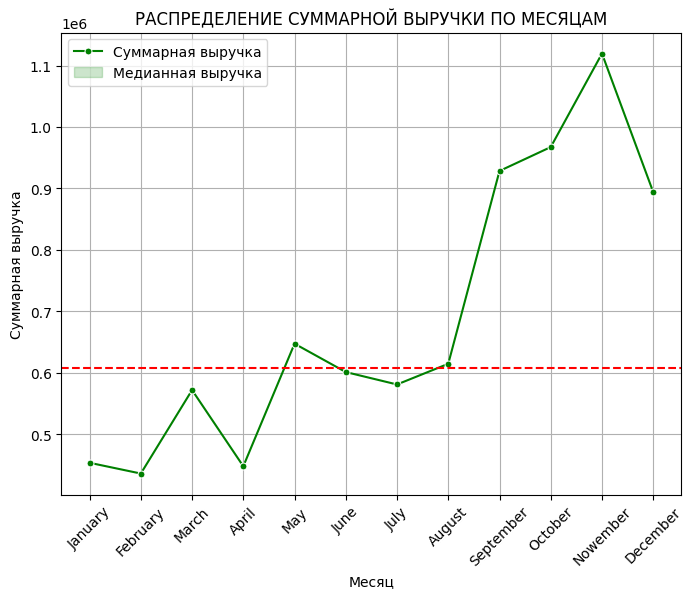

In [49]:
# Функция по номеру месяца возвращает его имя
def get_month(month):
    month_dict = {
                  1 : 'January',
                  2 : 'February',
                  3 : 'March',
                  4 : 'April',
                  5 : 'May',
                  6 : 'June',
                  7 : 'July',
                  8 : 'August',
                  9 : 'September',
                  10 : 'October',
                  11 : 'Nowember',
                  12 : 'December'
                  }
    for key, value in month_dict.items():
        if month == key:
            return value

# Группируем общую цену по месяцам и записывем месяцы в признак
revenue_by_month = df.groupby(by='month',
                              as_index=False)['TotalPrice'].sum()
revenue_by_month['month'] = revenue_by_month['month'].apply(get_month)

# Строим график, отражающий изменение цены по месяцам
fig = plt.figure(figsize=(8, 6))
line = sns.lineplot(revenue_by_month,
                    x='month',
                    y='TotalPrice',
                    marker='o',
                    markersize=5,
                    color='green',
                    )
# Строим линию медианной общей цены
line.axhline(int(revenue_by_month['TotalPrice'].median()),
             color='r',
             linestyle='--')

plt.xticks(rotation=45)
line.set_title('Распределение суммарной выручки по месяцам'.upper())
line.set_xlabel('Месяц')
line.set_ylabel('Суммарная выручка');
plt.legend(labels=['Суммарная выручка', 'Медианная выручка'])
plt.grid()

На графике видны три резких роста суммарной выручки. Выручка с Января по апрель ниже медианной, летние месяцы находятся примерно на ее уровне. С сентября начинается резкий рост с пиком в ноябре. 

Скорее всего все периоды роста выручки связаны с тем, что клиенты приобретают подарки к праздникам, самыми популярными из которых являются Рождество и Новый год.

###  4.6
Посмотрим как зависит количество заказов от дня недели


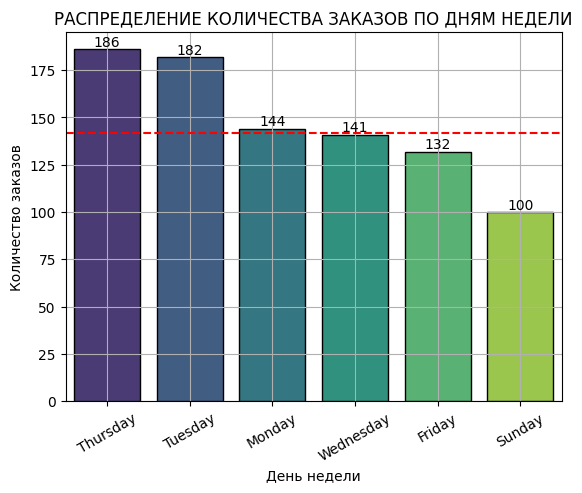

In [50]:
# Функция возвращает название дня недели по его порядковому номеру
def get_day_name(day):
    days_dict = {
                0 : 'Monday',
                1 : 'Tuesday',
                2 : 'Wednesday',
                3 : 'Thursday',
                4 : 'Friday',
                5 : 'Saturday',
                6 : 'Sunday'
                }
    for key, value in days_dict.items():
        if day == key:
            return value

# Группируем количество заказов по дню недели
week_orders = df.groupby(by='day of week', as_index=False)['Quantity'].value_counts()
week = week_orders['day of week'].value_counts().reset_index().rename(columns={'index' : 'day of week',
                                                                        'day of week' : 'quantity'})
week['day of week'] = week['day of week'].apply(get_day_name)

# Строим столбчатую диаграмму
bar = sns.barplot(week,
                  x='day of week',
                  y='quantity',
                  palette='viridis')
# Строим линию медианного количества заказов
bar.axhline(int(week['quantity'].median()),
             color='r',
             linestyle='--')

bar.set_title('Распределение количества заказов по дням недели'.upper())
bar.set_xlabel('День недели')
bar.set_ylabel('Количество заказов')
bar.bar_label(bar.containers[0])
plt.xticks(rotation=30)
plt.grid();

В датасете отсутствуют данные за субботу. Возможно, она является выходным днем.

Наибольшая активность клиентов в четверг и вторник. Меньше покупок совершается в воскресение.

### 4.7
Выделим дату из признака времени совершения транзакции.
Сгруппируем данные по датам и часам совершения транзакции и найдём количество заказов на каждый день-час. Затем найдём среднее количество ежедневно поступающих заказов в каждый из часов.

Построим визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

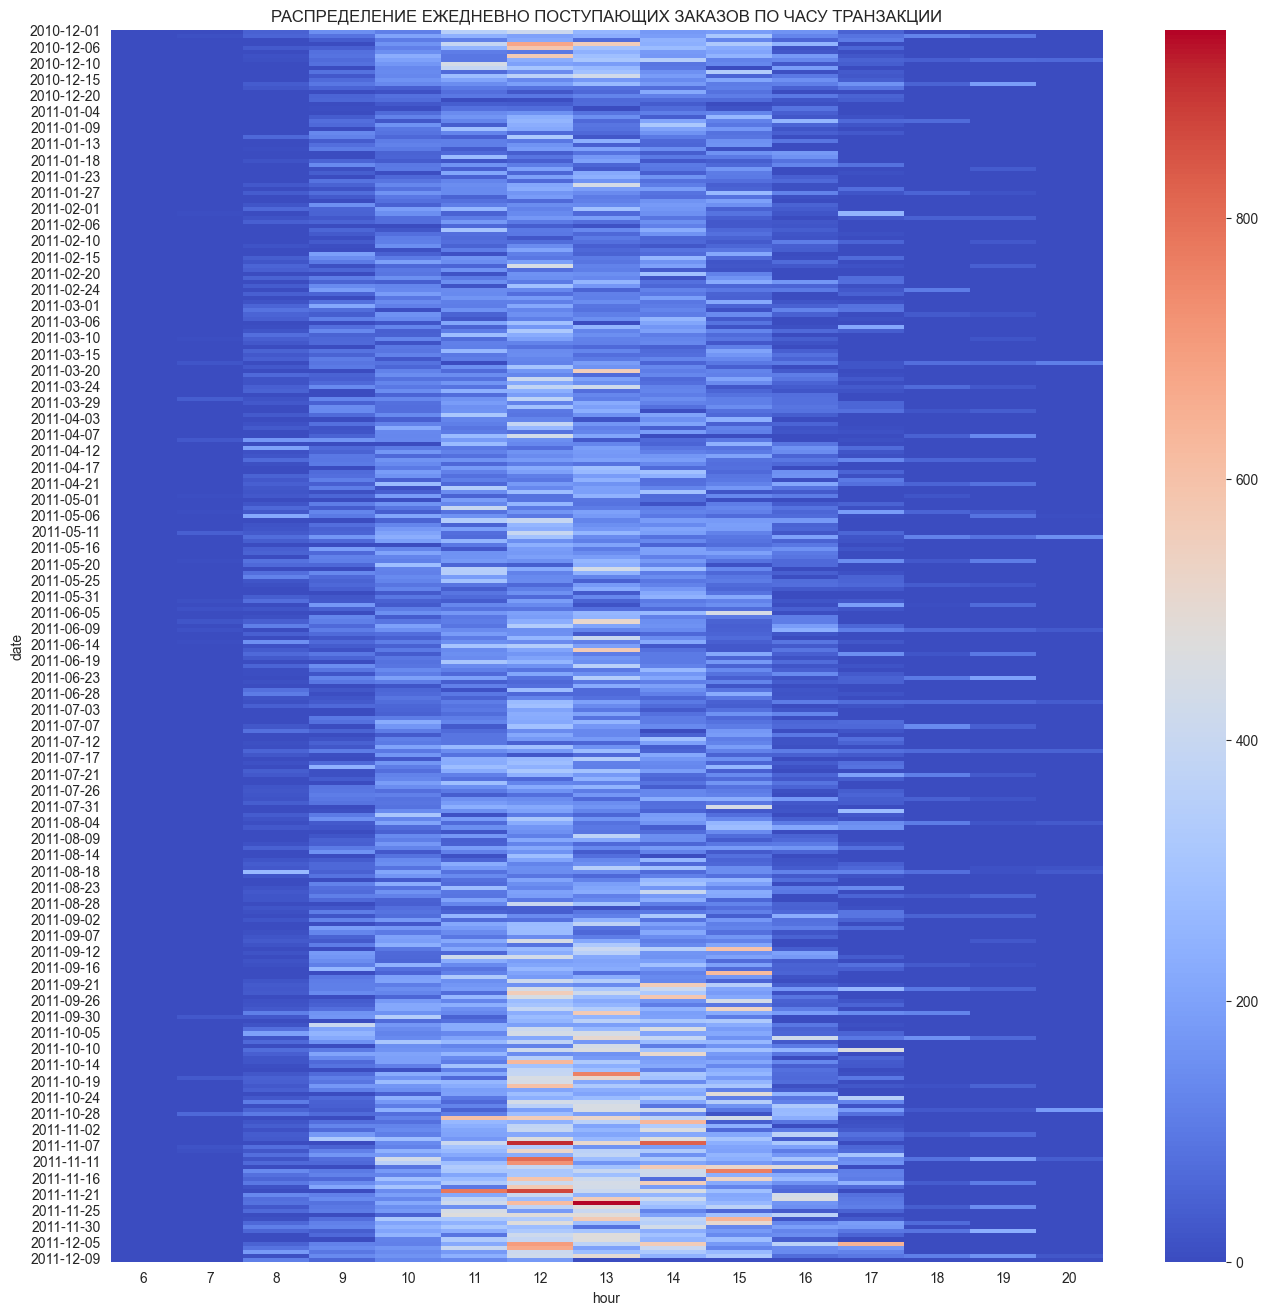

In [297]:
# Выделяем признак даты
df['date'] = df['InvoiceDate'].dt.date
# Строим сводную таблицу
date_table = pd.pivot_table(
                           df,
                           values='Quantity',
                           index='date',
                           columns='hour',
                           aggfunc='count',
                           fill_value=0
                              )

# Строим тепловую карту
fig = plt.figure(figsize=(16, 16))
hit = sns.heatmap(date_table, cmap='coolwarm')
hit.set_title('Распределение ежедневно поступающих заказов по часу транзакции'.upper());

Самое популярное время для покупок с 10 до 15 часов. Если учесть, что большая их часть делается в будние дни, то клиенты, возможно, предпочитают делать заказы подарков с работы. При наличии данных можно изучить с каких устройств чаще делаются заказы.

С 23 часов до 6 утра информация о заказах отсутствует.

## 5. RFM-сегментация клиентов: часть 1

Метод RFM заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.

Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

### 5.1 Создание RFM-таблицы

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

In [51]:
# Задаем точку отсчета - 10 декабря 2011 года
now = pd.to_datetime('2011-12-10')
# Словарь с расчетами значений
custom_aggregation = {
    'InvoiceDate':  lambda x: (now - x.max()).days, # recency: точка отсчета - последний заказ
    'InvoiceNo': lambda x: len(x.unique()), # frequency: длинна списка уникальных номеров заказов
    'TotalPrice': lambda x: x.sum(), # monetary value: сумма цен, приобретенных товаров каждым клиентом
}

# Группируем по идентификаторам клиентов
rfm_table = df.groupby('CustomerID').agg(custom_aggregation)
# Переименовываем признаки
rfm_table = rfm_table.rename(
    columns={
        'InvoiceDate': 'Recency',
        'InvoiceNo': 'Frequency',
        'TotalPrice': 'Monetary',
        'TotalQuantity': 'MeanQuantity'
        }
)
# Выводим первые 5 строк таблицы
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [52]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_1.html')
fig.show()

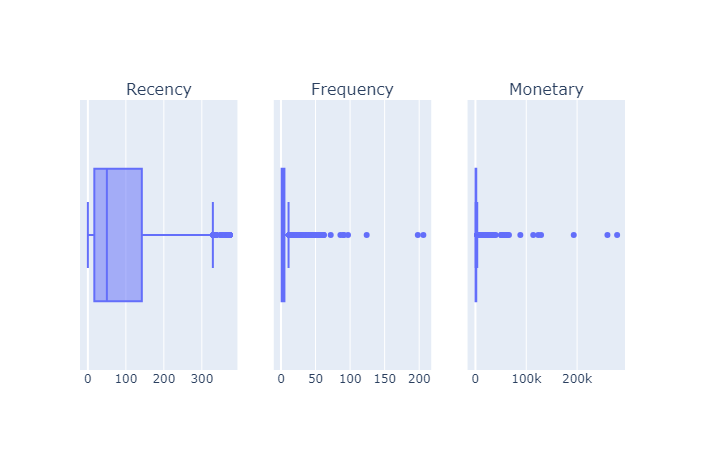

Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.

Удалим из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 

In [54]:
# Удаляем из таблицы записи, которые соответствуют одному из условий
rfm = rfm_table.drop( rfm_table[(rfm_table['Frequency'] > rfm_table['Frequency'].quantile(0.95)) | (rfm_table['Monetary'] > rfm_table['Monetary'].quantile(0.95))].index )
print(f'Осталось {rfm.shape[0]} записи')

Осталось 4044 записи


Посмотрим на коробчатые диаграммы после удаления выбросов

In [55]:
boxes = [px.box(rfm, x=column) for column in rfm.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_2.html')
fig.show()

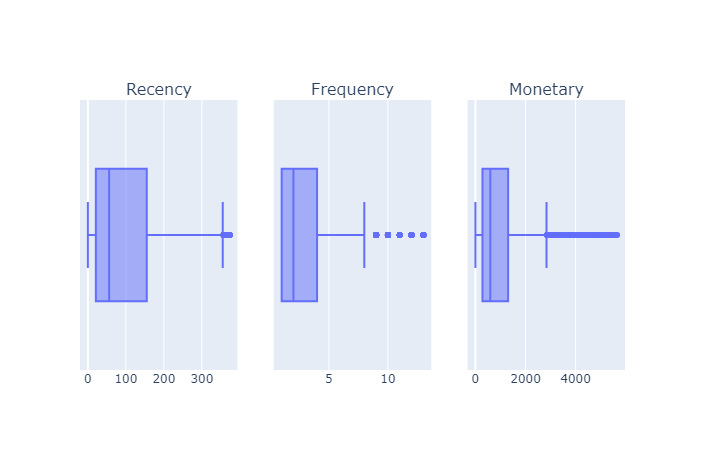

### 5.2 Кластеризация

Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:

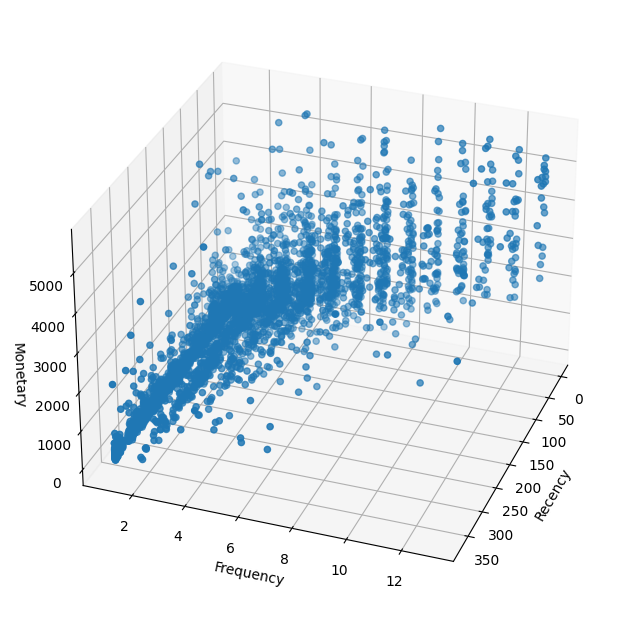

In [56]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z,
# а также информацию о группировке данных по цветам
ax.scatter(
    rfm['Recency'].to_list(), 
    rfm['Frequency'].to_list(),
    rfm['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


На графике нельзя увидеть ничего конкретного. Видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Воспользуемся методами снижения размерности.

### 5.3 PCA. Метод главных компонент

Начнём с метода главных компонент (PCA). Для его стабильной работы данные необходимо стандартизировать/нормализовать. 

In [57]:
from sklearn.pipeline import Pipeline
# Шкалируем данные с помощью StandardScaler и применяем PCA
pipeline = Pipeline([('scaler', preprocessing.StandardScaler()),
                              ('pca', decomposition.PCA(n_components=2))])
X = pipeline.fit_transform(rfm)
# Смотрим какую долю дисперсии объясняет каждая из компонент
variance = [round(x, 2) for x in pipeline['pca'].explained_variance_ratio_]
variance

[0.68, 0.24]

In [58]:
# Создаем датафрейм из трансформированных данных
rfm_pca = pd.DataFrame(X, columns=['axis-1', 'axis-2'])
rfm_pca.head()

,axis-1,axis-2
0,-2.135201,1.401596
1,3.447125,0.852872
2,0.629103,0.083217
3,0.152932,-0.720954
4,-1.888765,1.382645


Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

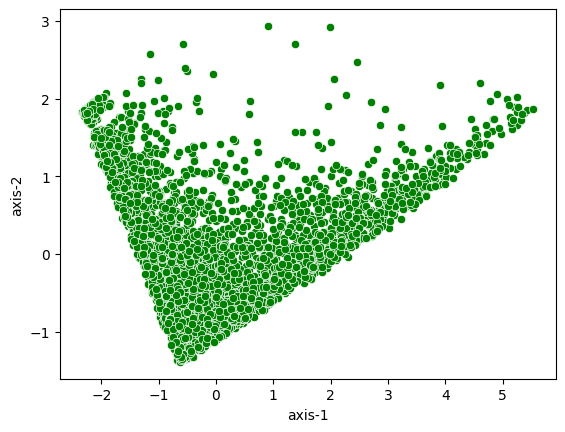

In [59]:
sns.scatterplot(data=rfm_pca,
                x='axis-1',
                y='axis-2',
                color='green'
                );

Судя по форме пространства, мы можем с уверенностью сказать, что нам не подойдут алгоритмы, основанные на плотности, такие как DBSCAN, так как точки расположены очень близко друг к другу и большая часть точек будет определена в единый кластер, что не имеет смысла.

Попробуем разделить это пространство главных компонент на сегменты. 

### 5.4 KMeans. Алгоритм k-средних.

Попробуем воспользоваться методом k-means. 

В начале работы алгоритма выбираются $k$
случайных центров в пространстве признаков. Каждый объект выборки относят к тому кластеру, к центру которого объект оказался ближе. Далее центры кластеров пересчитывают как среднее арифметическое векторов признаков всех вошедших в этот кластер объектов (то есть центр масс кластера). Как только мы обновили центры кластеров, объекты заново перераспределяются по ним, а затем можно снова уточнить положение центров. Процесс продолжается до тех пор, пока центры кластеров не перестанут меняться.

Оба шага алгоритма работают на уменьшение среднего квадрата евклидова расстояния от объектов до центров их кластеров:

$\Phi_0 = \frac{1}{nK} \sum\limits_{k=1}^{K} \sum\limits_{i=1}^{n} (\mu_k - x_i)^2 \mathbb{I}[a(x_i)=k]$

Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. 

Коэффициент силуэта - мера того насколько объект похож на объекты из своего собственного кластера по сравнению с объектами из других кластеров.

Коэффициент силуэта вычисляется по следующей формуле:

$s_{i}=\frac{\left(b_{i}-a_{i}\right)}{\max \left(a_{i}, b_{i}\right)}$

где:

+ $a_i$ — среднее расстояние от данного объекта $x_i$ до объектов из того же кластера;
+ $b_i$ — среднее расстояние от данного объекта $x_i$ до объектов из другого ближайшего кластера.

<AxesSubplot:xlabel='cluster', ylabel='silhouette'>

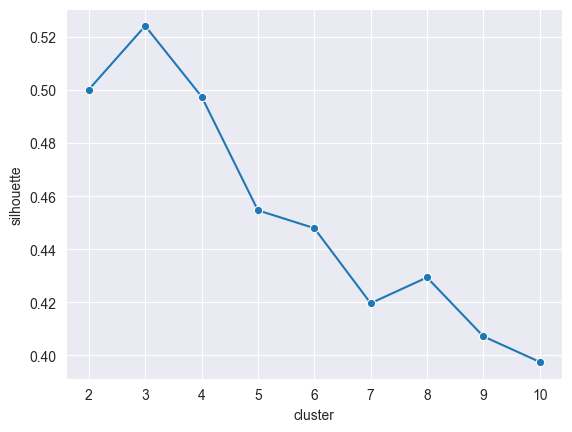

In [60]:
from sklearn.metrics import silhouette_score
# напишем функцию, которая на вход принимет количество кластеров и данные
def get_silhouette(cluster_num, X):
    k_means =  cluster.KMeans(n_clusters=cluster_num,
                              init='k-means++',
                              n_init=10,
                              random_state=42)
    k_means.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(2, 11):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, rfm_pca))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

Лучшее значение коэффициента силуэта получаем при 3 кластерах.

### 5.5 GMM. Модель гауссовой смеси.

Теперь возьмём EM-алгоритм.

Алгоритм ищет параметры модели итеративно, каждая итерация состоит из двух шагов:

+ E (Expectation) шаг — поиск наиболее вероятных значений скрытых переменных.

+ M (Maximization) шаг — поиск наиболее вероятных значений параметров, для полученных на шаге E значений скрытых переменных.

Подберем оптимальное количество кластеров для EM-алгоритма с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.

<AxesSubplot:xlabel='cluster', ylabel='silhouette'>

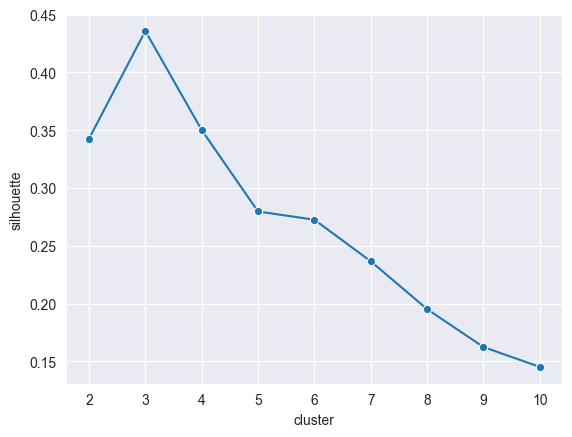

In [61]:
def get_silhouette(cluster_num, X):
    GM =  mixture.GaussianMixture(n_components=cluster_num,
                                       random_state=42)
    GM.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, GM.predict(X))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(2, 11):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, rfm_pca))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

Обольший коэффициент силуэта показала модель k-means/

Обучим ее на 3 кластерах.

In [62]:
# Обучаем модель
k_means = cluster.KMeans(n_clusters=3, random_state=42)
k_means.fit(rfm_pca)
# Метки кластеров
rfm_pca.loc[:, 'Label'] = k_means.labels_

In [63]:
# Посмотрим на распределение кластеров
clusters = pd.Series(k_means.labels_)
df = pd.concat([rfm_pca, clusters], axis=1)
df = df.rename(columns={0 : 'cluster'})
df['cluster'].value_counts().sort_values(ascending=False)

0    2267
2    1001
1     776
Name: cluster, dtype: int64

Визуализируем результаты кластеризации:

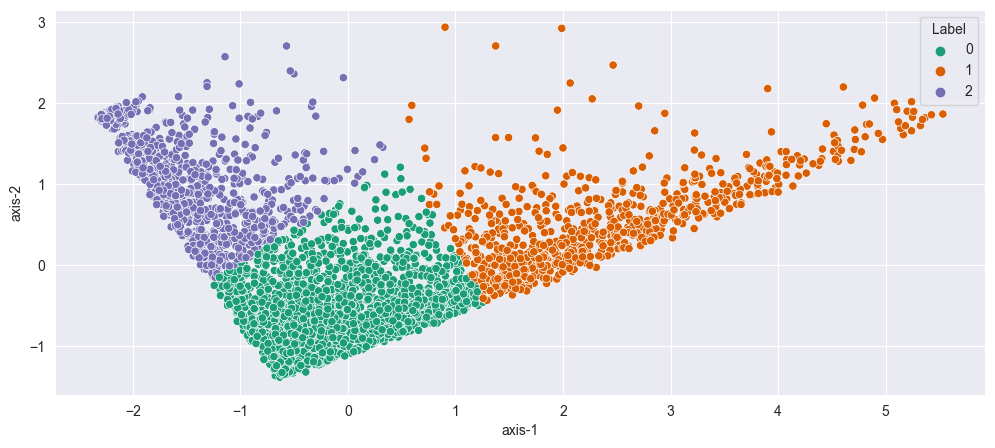

In [64]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_pca, 
    x='axis-1', 
    y='axis-2', 
    hue='Label',
    palette='Dark2'
);

Итак, у нас есть три сегмента клиентов. Попробуем составить профиль для этих сегментов.

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппирем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

In [65]:
rfm_labels = pd.concat([rfm.reset_index(), clusters], axis=1).rename(columns={0 : 'cluster'})
rfm_mean_cluster = rfm_labels.groupby(by='cluster',
                                      as_index=False)[['Recency',
                                                       'Frequency',
                                                       'Monetary']].mean().round()
rfm_mean_cluster

,cluster,Recency,Frequency,Monetary
0,0,51.0,2.0,660.0
1,1,32.0,7.0,2658.0
2,2,253.0,1.0,387.0


Для анализа кластеров напишем функцию, которая визуализирует полярную диаграмму.

In [66]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data),
                                columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()    

Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

In [67]:
plot_cluster_profile(grouped_data=rfm_mean_cluster, n_clusters=3)

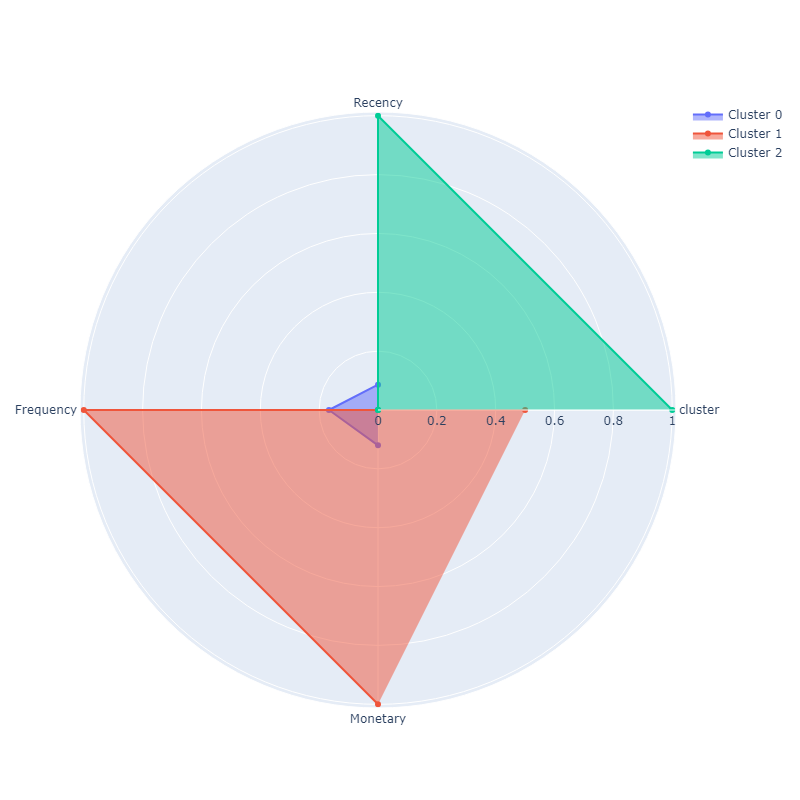

Описание кластера:
* Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 2 соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер 0 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

### 6. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

Попробуем использовать нелинейную трансформацию признаков. 

###  6.1 t-SNE. Стохастическое вложение соседей с t-распределением.

Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Рассчитаем значение дивергенции Кульбака-Лейблера.

Дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. 

In [68]:
# Создаем пайплайн: шкалируем данные с помощью StandardScaler и применяем TSNE
pipeline2 = Pipeline([
           ('scaler', preprocessing.StandardScaler()),
           ('tsne', manifold.TSNE(n_components=2,
                                  perplexity=50,
                                  random_state=100))])
X = pipeline2.fit_transform(rfm)
print(pipeline2['tsne'].kl_divergence_)
rfm_tsne = pd.DataFrame(X, columns=['axis1', 'axis2'], index = rfm.index)

0.5415332317352295


In [69]:
rfm_tsne.head()

,axis1,axis2
CustomerID,,
12346,-5.096237,32.750000
12347,19.839493,30.269058
12348,30.227396,-1.920902
12349,9.074645,-19.684454
12350,-8.583499,27.215914


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


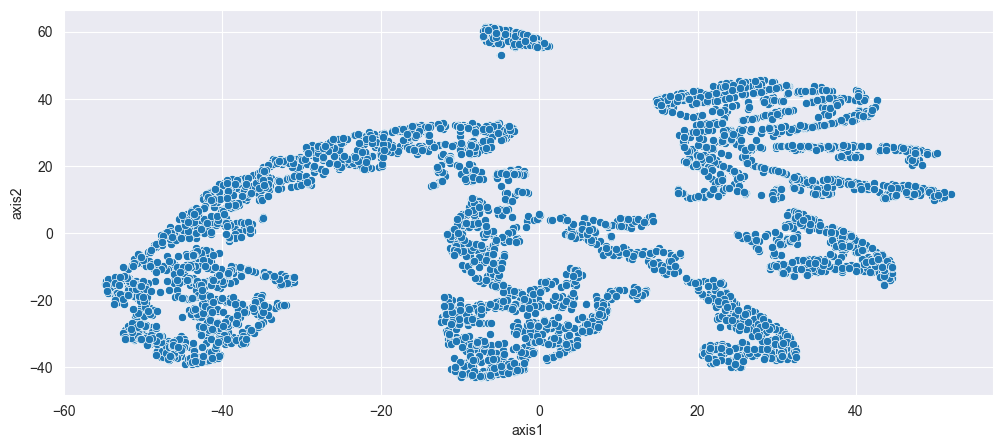

In [70]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_tsne, x='axis1', y='axis2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### 6.2 k-means.

Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

<AxesSubplot:xlabel='cluster', ylabel='silhouette'>

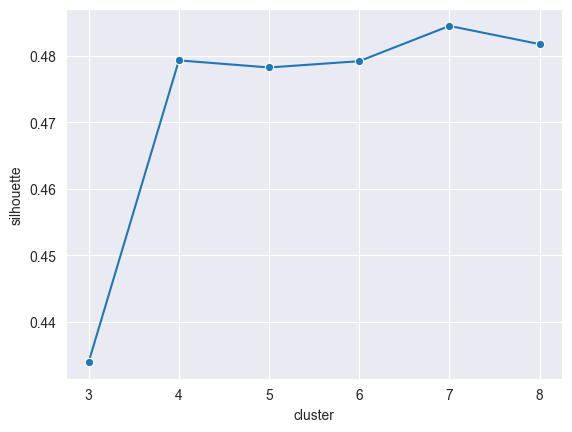

In [71]:
# напишем функцию, как и при подсчете метода локтя
def get_silhouette(cluster_num, X):
    k_means =  cluster.KMeans(n_clusters=cluster_num,
                              init='k-means++',
                              n_init=10,
                              random_state=42)
    k_means.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(3, 9):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, rfm_tsne))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

### 6.3 GMM.
Посмотрим на результаты EM-алгоритма. 

Подберем оптимальное количество кластеров для EM-алгоритма с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

<AxesSubplot:xlabel='cluster', ylabel='silhouette'>

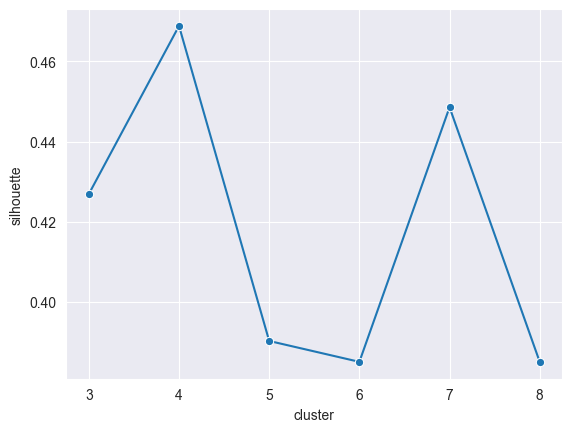

In [72]:
def get_silhouette(cluster_num, X):
    GM =  mixture.GaussianMixture(n_components=cluster_num,
                                       random_state=42)
    GM.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, GM.predict(X))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(3, 9):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, rfm_tsne))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

Алгоритм k-means опять показал лучший результат по коэффициенту силуэта.

Обучиим лучшую модель с подобранным количеством кластеров на декомпозированных данных. 

In [73]:
KM = cluster.KMeans(n_clusters=7,
                    random_state=42)
KM.fit_predict(rfm_tsne)
clusters = pd.Series(KM.labels_).value_counts()
clusters.sort_values(ascending=False)

1    914
5    683
0    656
2    543
4    446
6    405
3    397
dtype: int64

Визуализируем результаты кластеризации:

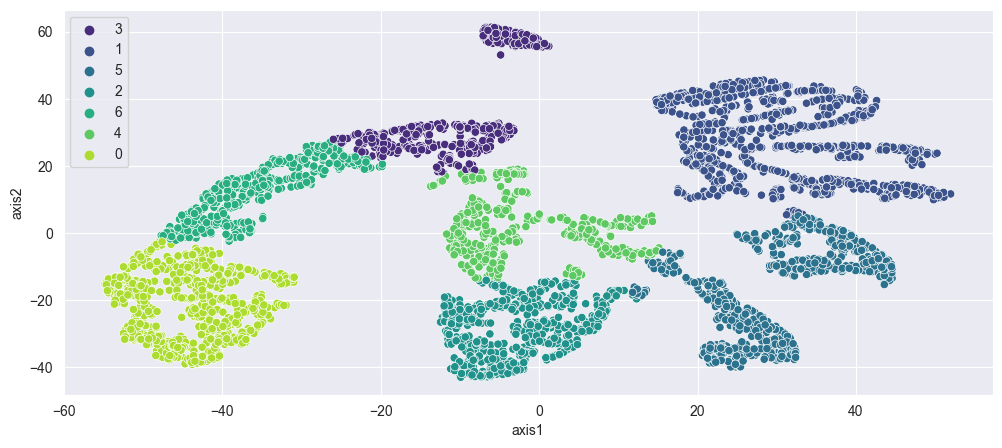

In [74]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_tsne,
                x='axis1',
                y='axis2',
                hue=KM.labels_.astype('str'),
                palette='viridis');


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


### 6.6 Профили кластеров.

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков. Для наглядности округлим все значения в столбцах до целого числа.

In [75]:
rfm_labels = pd.concat([rfm.reset_index(), pd.Series(KM.labels_)], axis=1).rename(columns={0 : 'cluster'})
rfm_mean_cluster_KM = rfm_labels.groupby(by='cluster')[['Recency',
                                                       'Frequency',
                                                       'Monetary']].mean().round()
rfm_mean_cluster_KM

,Recency,Frequency,Monetary
cluster,,,
0,46.0,1.0,322.0
1,32.0,7.0,2417.0
2,40.0,2.0,614.0
3,313.0,1.0,261.0
4,196.0,2.0,670.0
5,40.0,3.0,995.0
6,181.0,1.0,273.0


Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

In [339]:
plot_cluster_profile(grouped_data=rfm_mean_cluster_KM, n_clusters=7)

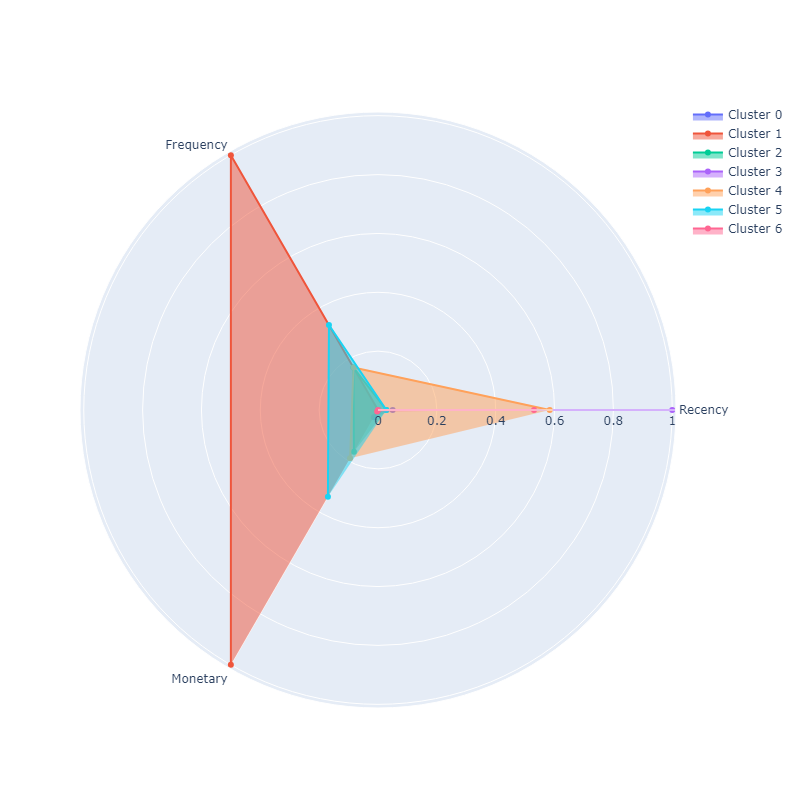

* Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 4 соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер 2 соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер 5 соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер 0 соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер 6 соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер 3 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.


## 7. RFM-кластеризация клиентов: часть 3. Предсказание кластера для клиентов, не попавших в выборку.

Мы обучали алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Чтобы решить эту проблему сведём задачу кластеризации к классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. 

Разделите исходные данные на тренировочную и тестовую выборки в соотношении 80/20. 

In [77]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm #очищенная RFM-таблица
y = KM.labels_ #метки кластеров, предсказанные ранее

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size=0.2,
                                                                    random_state=42)
print('X_train :', X_train.shape)
print('X_test :', X_test.shape)
print('y_train :', y_train.shape)
print('y_test :', y_test.shape)

X_train : (3235, 3)
X_test : (809, 3)
y_train : (3235,)
y_test : (809,)


Дальше осталось только построить несколько моделей и выбрать из них лучшую. 
Алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче  мало чем помогут. Поэтому воспользуемся ансамблевыми методами над деревьями решений.

### 7.2 Random Forest Classifier.

Начнём со случайного леса. 

Для оценки качества модели используем метрику accuracy.

Accuracy - это метрика, которая характеризует качество модели, агрегированное по всем классам. 

$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$

Подберем оптимальные значения гиперпараметров с помощью GridSearch

In [78]:
# Сетка гиперпараметров
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

# создаем объект GridSearch
grid = model_selection.GridSearchCV(estimator=ensemble.RandomForestClassifier(random_state=42),
                                    param_grid=param_grid,
                                    scoring='accuracy',
                                    cv=5,
                                    n_jobs=-1,
                                    return_train_score=True)
# Обучаем модель
grid.fit(X_train, y_train)
# Значения лучших гиперпараметров
grid.best_params_

{'criterion': 'gini', 'max_depth': 13, 'n_estimators': 200}

In [79]:
# Создаем модель случайного леса и обучаем на лучших гиперпараметрах
model_rf = ensemble.RandomForestClassifier(**grid.best_params_,
                                           random_state=42,
                                           n_jobs=-1)

model_rf.fit(X_train, y_train)
y_train_pred = model_rf.predict(X_train)
y_test_pred = model_rf.predict(X_test)

print(f'Accuracy train: {round(metrics.accuracy_score(y_train, y_train_pred),3)}')
print(f'Accuracy test: {round(metrics.accuracy_score(y_test, y_test_pred), 3)}')

Accuracy train: 1.0
Accuracy test: 0.985


Значение метрики accuracy очень высокое, но не идеальное. Попробуем его улучшить, воспользовавшись бустингом.

### 7.3 Gradient Boosting

In [353]:
# Сетка гиперпараметров
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
# Обучаем объект GridSearch
grid_gb = model_selection.GridSearchCV(estimator=ensemble.GradientBoostingClassifier(random_state=42),
                                    param_grid=param_grid,
                                    scoring='accuracy',
                                    cv=5,
                                    n_jobs=-1,
                                    return_train_score=True)
# Мобучаем модель
grid_gb.fit(X_train, y_train)
# Лучшие гиперпараметры
grid_gb.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}

In [355]:
# Обучаем градиентный бустинг на оптимальных гиперпараметрах
model_gb = ensemble.GradientBoostingClassifier(**grid_gb.best_params_,
                                           random_state=42
                                           )

model_gb.fit(X_train, y_train)
y_train_pred_gb = model_gb.predict(X_train)
y_test_pred_gb = model_gb.predict(X_test)

print(f'Accuracy train: {round(metrics.accuracy_score(y_train, y_train_pred_gb),3)}')
print(f'Accuracy test: {round(metrics.accuracy_score(y_test, y_test_pred_gb), 3)}')

Accuracy train: 1.0
Accuracy test: 0.983


Значение метрики accuracy примерно одинаковое. Random Forest показал незначительно лучший результат.

Построенная модель может с точностью 98% процентов отнести нового клиента интернет-магазина к тому или иному кластеру, а соответсвенно мы сможем спрогнозировать его поведение и подобрать лучшую стратегию взаимодействия.